In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy
pip install tweepy==3.10.0

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
G

In [ ]:
# JAVA_HOME 환경변수 설정하기
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
train = pd.read_excel('/content/drive/MyDrive/temp/Newsletter_Board/데이터_2022.05.18.xlsx')
train_raw = train.copy()

In [ ]:
import pandas as pd
import numpy as np
import random
import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

In [ ]:
train.head()

,Title,url,thumbnail
0,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...
1,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...
2,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...
3,"넥슨, 라프텔과 가명정보 결합…""데이터 사이언스 강화""",https://www.news1.kr/articles/?4683961,https://search.pstatic.net/common/?src=https%3...
4,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...


# 전처리

### 불용어 제거
한글은 따로 불용어 사전이 존재하지 않기에 불용어 사전을 직접 정의해줘야 함 -> 일반적으로 접속사나 조사 등을 불용어로 정의  
기본 불용어는 https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt 를 참고하고, 이후 단어 빈도수를 확인한 뒤에 불용어를 추가 정의해주는 방향

In [ ]:
komoran = Komoran()
hannanum = Hannanum()

In [ ]:
with open('/content/drive/MyDrive/temp/Newsletter_Board/stopwords.txt', 'r', encoding='cp949') as f:
  list_file = f.readlines() 
stopwords = list_file[0].split(",")

# 정규화
def preprocess(text):
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def final(text):
    n = []
    word = komoran.nouns(text)
    p = komoran.pos(text)
    for pos in p:
      if pos[1] in ['SL']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return final(preprocess(text))

In [ ]:
train['noun'] = train['Title'].apply(lambda x: finalpreprocess(x))
train

,Title,url,thumbnail,noun
0,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...,과학 방역 중대 전문가 위원회 데이터 플랫폼 구성
1,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...,넥슨 가명 정보 결합 데이터 사이언스 강화
2,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...,인공위성 세종 한글과컴퓨터 이미지 데이터
3,"넥슨, 라프텔과 가명정보 결합…""데이터 사이언스 강화""",https://www.news1.kr/articles/?4683961,https://search.pstatic.net/common/?src=https%3...,넥슨 가명 정보 결합 데이터 사이언스 강화
4,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...,스페이스 데이터 서비스 진출 글로벌 브랜드 KT SAT
...,...,...,...,...
2616,﻿[2022지방선거] ﻿1400만 경기도민 표심 잡아라…경기도지사 후보 김동연 vs...,http://www.smartfn.co.kr/view.php?ud=202205181...,https://search.pstatic.net/common/?src=https%3...,지방 선거 경기도민 표심 경기도지사 후보 김동연 김은혜 vs
2617,"[사설] 가팔라질 기준금리 인상, 부채위기 확산 막아야",https://www.etoday.co.kr/news/view/2134715,,사설 기준 금리 인상 부채 위기 확산
2618,﻿[2022지방선거] 세종시장 후보 이춘희 “행정수도 완성” vs 최민호 “윤석열 ...,http://www.smartfn.co.kr/view.php?ud=202205181...,https://search.pstatic.net/common/?src=https%3...,지방 선거 세종 시장 후보 이춘희 행정 수도 완성 최민호 윤석열 정부 시작 vs
2619,"뉴욕증시 비트코인 흔들 제롬파월 연설 ""자이언트 빅스텝"" 소매판매 0.9%",http://www.g-enews.com/ko-kr/news/article/news...,https://search.pstatic.net/common/?src=https%3...,뉴욕 증시 비트코인 제롬 파월 연설 자이언트 스텝 소매 판매


## 키워드 포함 행만 추출

In [ ]:
user_keyword = ['데이터', '머신러닝', '디지털', 'AI', '스마트', 	'DB', 'KAIST', '딥러닝', '기계학습', 'IT', '플랫폼', '블록체인', 	'핀테크', 'AWS', '구글', 'Google']

In [ ]:
def extract_keyword(train):  #train은 dataframe
		user_keywords = '|'.join(user_keyword)
		temp = train[train['noun'].str.contains(user_keywords)]
		train_extract = temp[['Title', 'url', 'thumbnail']]
		train_extract
		return train_extract

# 한나눔 전처리
def final_han(text):
    n = []
    word = hannanum.nouns(text)
    p = hannanum.pos(text)
    for pos in p:
      if pos[1] in ['F']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess_han(text):
  return final_han(preprocess(text))

# hannanum - not join
def han2(text):
    n = []
    word = hannanum.nouns(text)
    p = hannanum.pos(text)
    for pos in p:
      if pos[1] in ['F']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return n

# preprocess + han2
def han2list(text):
  return han2(preprocess(text))

In [ ]:
train_extract = extract_keyword(train)
train_extract['noun'] = train_extract['Title'].apply(lambda x: finalpreprocess_han(x))
train_extract

,Title,url,thumbnail,noun
0,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성
1,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화
2,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...,인공위성 세종 한글과컴퓨터 이미지 데이터
3,"넥슨, 라프텔과 가명정보 결합…""데이터 사이언스 강화""",https://www.news1.kr/articles/?4683961,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화
4,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...,스페이스데이터 서비스 진출 글로벌 브랜드 KT SAT
...,...,...,...,...
2585,"수자원공사, 제1차 디지털 혁신 릴레이포럼 개최",http://www.ikld.kr/news/articleView.html?idxno...,,수자원공사 디지털 혁신 릴레이포럼 개최
2590,한양대 임창환 교수 AI로 가상의 뇌파신호 생성기술 개발,http://www.veritas-a.com/news/articleView.html...,https://search.pstatic.net/common/?src=https%3...,한양대 임창환 교수 가상 뇌파신호 생성기술 개발 AI
2595,"신한베트남은행, 디지털 사업 전담 추진 조직 'Future Bank Group' 출범",https://www.onews.tv/news/articleView.html?idx...,https://search.pstatic.net/common/?src=https%3...,신한베트남은행 디지털 사업 전담 추진 조직 출범 Future Bank Group
2599,한화·교보생명 오너 3세 ‘디지털’ 대결…누가 웃나,https://www.fetv.co.kr/news/article.html?no=11...,https://search.pstatic.net/common/?src=https%3...,한화 교보생명 오너 디지털 대결


In [ ]:
# train_extract.to_csv('/content/drive/MyDrive/temp/Newsletter_Board/final_han_preprocess.csv', index=False)

# 모델링

## #1 Clustering
같은 기사끼리 묶기

In [ ]:
text = train_extract['noun']

In [ ]:
#1 tf-idf 임베딩(+Normalize)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5)) #min_df :최소 빈도값 (단어 등장하는 문서 수)
tfidf_vectorizer.fit(text)
vector = tfidf_vectorizer.transform(text).toarray()

vector = np.array(vector) # Normalizer를 이용해 이미 변환된 벡터

In [ ]:
#2 DBSCAN Clustering

model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
#     거리 계산 식으로는 Cosine distance를 이용
#     eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움
result = model.fit_predict(vector)
train_extract['cluster1st'] = result

print('군집개수 :', result.max())
train_extract

군집개수 : 494


,Title,url,thumbnail,noun,cluster1st
0,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성,0
1,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화,1
2,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...,인공위성 세종 한글과컴퓨터 이미지 데이터,2
3,"넥슨, 라프텔과 가명정보 결합…""데이터 사이언스 강화""",https://www.news1.kr/articles/?4683961,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화,1
4,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...,스페이스데이터 서비스 진출 글로벌 브랜드 KT SAT,3
...,...,...,...,...,...
2585,"수자원공사, 제1차 디지털 혁신 릴레이포럼 개최",http://www.ikld.kr/news/articleView.html?idxno...,,수자원공사 디지털 혁신 릴레이포럼 개최,360
2590,한양대 임창환 교수 AI로 가상의 뇌파신호 생성기술 개발,http://www.veritas-a.com/news/articleView.html...,https://search.pstatic.net/common/?src=https%3...,한양대 임창환 교수 가상 뇌파신호 생성기술 개발 AI,393
2595,"신한베트남은행, 디지털 사업 전담 추진 조직 'Future Bank Group' 출범",https://www.onews.tv/news/articleView.html?idx...,https://search.pstatic.net/common/?src=https%3...,신한베트남은행 디지털 사업 전담 추진 조직 출범 Future Bank Group,494
2599,한화·교보생명 오너 3세 ‘디지털’ 대결…누가 웃나,https://www.fetv.co.kr/news/article.html?no=11...,https://search.pstatic.net/common/?src=https%3...,한화 교보생명 오너 디지털 대결,260


In [ ]:
def print_cluster_result(train):
    # 군집별 기사 개수 세는 목적
    clusters = []
    counts = []
    # 대표 기사 추출
    top_title = []
    top_noun = []
    for cluster_num in set(result):
        # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
        # if(cluster_num == -1 or cluster_num == 0): 
        #     continue
        # else:
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train['cluster1st'] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            top_title.append(temp_df.reset_index()['Title'][0])
            top_noun.append(temp_df.reset_index()['noun'][0]) # 군집별 첫번째 기사를 대표기사로 ; tfidf방식
            for title in temp_df['Title']:
                print(title)
            print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'top_title':top_title, 'top_noun':top_noun})
    return cluster_result

In [ ]:
cluster1_result = print_cluster_result(train_extract)
cluster1_result

cluster num : 0
'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성
‘과학방역’ 나선 중대본, 전문가위원회·빅데이터 플랫폼 구성

cluster num : 1
넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화
넥슨, 라프텔과 가명정보 결합…"데이터 사이언스 강화"
넥슨, 라프텔과 가명정보 결합으로 데이터 사이언스 강화
넥슨, 라프텔과 가명정보 결합으로 데이터 사이언스 강화
넥슨, 라프텔과 가명정보 결합으로 데이터 사이언스 강화
넥슨 "라프텔과 가명정보 결합으로 데이터 사이언스 강화"

cluster num : 2
인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다

cluster num : 3
KT SAT "스페이스데이터 서비스 진출…글로벌 브랜드 키운다"

cluster num : 4
농협은행, 마이데이터 친구추천 이벤트 진행

cluster num : 5
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정 [하동소식]
하동군, 공공데이터 기업매칭 공모 선정 [하동소식]
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군 공공데이터 기업매칭 공모 선정

cluster num : 6
행안부, 공기관 포함 467개 기관 데이터기반행정 점검

cluster num : 7
교통사망사고 빅데이터로 도민생명 살린다
교통사망사고 빅데이터로 도민생명 살린다

cluster num : 8
“랜섬웨어 피해 기업 3곳 중 1곳, 대가 지불해도 데이터 복구 실패”
“랜섬웨어 피해 기업 3곳 중 1곳, 대가 지불해도 데이터 복구 실패”
랜섬웨어 피해 기업 76% 금전적 대가 지불... 3분의 1은 데이터 복구 못해

cluster num : 9
안산시, ‘공공데이터 기업매칭 지원사업’ 추진

,cluster_num,count,top_title,top_noun
0,0,2,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성
1,1,6,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",넥슨 라프텔 가명정보 결합 데이터 사이언스 강화
2,2,1,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",인공위성 세종 한글과컴퓨터 이미지 데이터
3,3,1,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",스페이스데이터 서비스 진출 글로벌 브랜드 KT SAT
4,4,1,"농협은행, 마이데이터 친구추천 이벤트 진행",농협은행 마이데이터 친구추천 이벤트 진행
...,...,...,...,...
490,490,1,인천경제자유구역 블록체인 특구화” 유정복 정책 공약 발표,인천경제자유구역 블록체 특구화 유정복 정책 공약 발표
491,491,1,"SK브로드밴드, 서울디지털재단과 콘텐츠 업무 협약",SK브로드밴드 서울디지털재단 콘텐츠 업무 협약
492,492,1,"이수화학, ICT 전시회 ‘GMV 2022’서 스마트팜 사업 성과 선보인다",이수화학 전시회 스마트팜 사업 ICT GMV
493,493,1,"신한베트남은행, 'Future Bank Group' 출범 선포...""디지털 뱅크 위...",신한베트남은행 출범 선포 디지털 뱅크 위상 강화 Future Bank Group


In [ ]:
cluster = pd.read_csv("/content/drive/MyDrive/temp/Newsletter_Board/cluster1_result.csv")
cluster

,cluster_num,count,top_title,top_noun
0,0,2,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성
1,1,6,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",넥슨 라프텔 가명정보 결합 데이터 사이언스 강화
2,2,1,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",인공위성 세종 한글과컴퓨터 이미지 데이터
3,3,1,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",스페이스데이터 서비스 진출 글로벌 브랜드
4,4,2,"농협은행, 마이데이터 친구추천 이벤트 진행",농협은행 마이데이터 친구추천 이벤트 진행
...,...,...,...,...
498,498,1,"SK브로드밴드, 서울디지털재단과 콘텐츠 업무 협약",SK브로드밴드 서울디지털재단 콘텐츠 업무 협약
499,499,1,"이수화학, ICT 전시회 ‘GMV 2022’서 스마트팜 사업 성과 선보인다",이수화학 전시회 스마트팜 사업
500,500,1,"신한베트남은행, 'Future Bank Group' 출범 선포...""디지털 뱅크 위...",신한베트남은행 출범 선포 디지털 뱅크 위상 강화
501,501,1,한화·교보생명 오너 3세 ‘디지털’ 대결…누가 웃나,한화 교보생명 오너 디지털 대결 누구


# #2 Clustering
유사도 높은 기사끼리 묶기

In [ ]:
text = cluster['top_noun']

cluster2 = cluster.copy()

In [ ]:
#1 tf-idf 임베딩
tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5))
tfidf_vectorizer.fit(text)
vector = tfidf_vectorizer.transform(text).toarray()

vector = np.array(vector)

## Elbow method

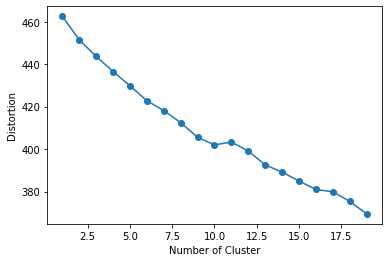

In [ ]:
#2 K-means clustering - Elbow method
def visualize_elbowmethod(data, param_init='random', param_n_init=20, param_max_iter=300):
    distortions = []
    for i in range(1, 20):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)

    plt.plot(range(1, 20), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

visualize_elbowmethod(vector)

In [ ]:
kmeans = KMeans(n_clusters=10).fit(vector)
print(kmeans.labels_)

[1 8 8 0 5 7 0 1 8 7 1 8 7 7 1 0 8 1 8 5 1 7 0 5 8 8 0 1 5 5 5 8 1 0 6 0 5
 8 1 0 4 0 0 1 8 1 7 8 8 8 1 6 8 0 0 8 8 0 8 1 1 1 0 1 4 8 8 8 1 8 8 0 0 0
 1 0 0 1 0 2 0 7 8 8 8 5 1 7 0 8 8 7 7 5 7 0 1 8 1 7 5 8 8 0 8 5 5 7 0 5 7
 7 8 0 1 5 7 0 8 0 7 8 0 1 0 0 1 0 4 8 5 7 5 7 0 6 2 2 2 6 0 9 1 0 0 0 6 4
 2 0 3 0 2 2 6 3 9 4 0 3 2 3 6 0 0 6 2 2 0 9 0 3 2 9 6 3 0 3 2 0 3 6 3 0 1
 0 2 9 6 0 0 2 0 0 6 9 2 0 1 3 6 0 3 0 2 7 3 0 0 7 9 3 0 9 3 0 9 6 9 1 0 0
 0 1 2 3 1 7 4 3 0 6 0 0 3 9 2 2 9 3 6 0 0 0 1 4 2 1 3 9 0 3 0 0 0 3 0 0 0
 2 0 2 0 3 1 0 3 0 1 0 0 0 3 2 7 0 9 1 0 3 0 9 0 0 3 6 2 2 0 1 3 6 4 0 0 4
 0 0 7 0 2 9 4 0 0 0 0 2 1 9 3 2 0 0 0 1 0 0 0 2 1 1 0 2 0 3 0 0 3 0 0 9 0
 3 0 0 1 0 0 3 3 0 1 1 3 3 0 7 3 0 0 0 1 0 0 0 0 0 0 0 1 0 6 4 4 0 0 0 0 0
 1 3 0 9 0 3 0 3 0 0 0 0 1 3 0 0 1 0 3 6 0 0 0 0 9 0 0 9 0 0 0 0 6 0 0 4 1
 1 0 0 0 0 0 0 0 0 0 4 0 0 0 3 0 0 0 0 0 0 1 0 0 1 6 0 3 1 0 4 0 0 0 0 0 1
 0 0 4 6 0 0 0 0 3 0 2 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 4 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 9 3 

In [ ]:
cluster['clusterlst'] = kmeans.labels_
cluster

,cluster_num,count,top_title,top_noun,clusterlst
0,0,2,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성,1
1,1,6,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",넥슨 라프텔 가명정보 결합 데이터 사이언스 강화,8
2,2,1,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",인공위성 세종 한글과컴퓨터 이미지 데이터,8
3,3,1,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",스페이스데이터 서비스 진출 글로벌 브랜드,0
4,4,2,"농협은행, 마이데이터 친구추천 이벤트 진행",농협은행 마이데이터 친구추천 이벤트 진행,5
...,...,...,...,...,...
498,498,1,"SK브로드밴드, 서울디지털재단과 콘텐츠 업무 협약",SK브로드밴드 서울디지털재단 콘텐츠 업무 협약,9
499,499,1,"이수화학, ICT 전시회 ‘GMV 2022’서 스마트팜 사업 성과 선보인다",이수화학 전시회 스마트팜 사업,0
500,500,1,"신한베트남은행, 'Future Bank Group' 출범 선포...""디지털 뱅크 위...",신한베트남은행 출범 선포 디지털 뱅크 위상 강화,3
501,501,1,한화·교보생명 오너 3세 ‘디지털’ 대결…누가 웃나,한화 교보생명 오너 디지털 대결 누구,3


In [ ]:
for cluster_num in set(cluster['clusterlst']):
  temp_df = cluster[cluster['clusterlst'] == cluster_num]
  print("cluster num : {} Number of news : {}".format(cluster_num, len(temp_df)))
  for title in temp_df['top_title']:
    print(title)
  print()

cluster num : 0 Number of news : 223
KT SAT "스페이스데이터 서비스 진출…글로벌 브랜드 키운다"
행안부, 공기관 포함 467개 기관 데이터기반행정 점검
한국축산데이터, 축산분야 亞최초 영국 GEP 선정…"유럽 진출 본격화"
[빅데이터MSI]18일 오전 주식시장 심리 4단계 '보통'
샴푸 브랜드평판 2022년 5월 빅데이터 분석결과
[데이터뉴스]'벤처펀드 1조' VC 7곳
한국빅데이터학회, '빅데이터AI포럼' 창립
[현장] 아시아 최대 KTSAT 금산위성센터, 우주데이터 사업 기지 된다
한세예스24홀딩스, 박현영 데이터분석가 초청해 강연회 열어
DB손해보험, AI·빅데이터 전문가로 '디지털 혁신팀' 운영…쌍방향 'TM 상품·청약서비스'로 편의성 높여
한국데이터법정책학회, 20일 "데이터법과 정책의 이슈와 과제" 정기학술대회
[데이터경제] 중국, 어느새 비트코인 채굴 2위로 부상...중국정부, 금지 조치에도 급증
하나금융 함영주 디지털 리더십, 빅데이터 시대 맞춤 전략 통했다
(친환경이 미래다⑩)'전기 먹는 하마' 데이터센터…"친환경 전력 사용 고려해야"
인천 이젠아카데미컴퓨터학원, IT 취업 도움되는 '빅데이터 분석 머신러닝 개발(파이썬, 캐글, 클로바)' 국비지원 개강
[시론] 스마트팜은 데이터농업이다
서울시의회, 지방분권 활동 강화·빅데이터 활용 의정활동 지원··· 풀뿌리 주민자치 확립
“인천경제자유구역 블록체인 특구화하겠다” 유정복
AI는 미래 경찰관! '대한민국 바꿀 10가지 기술'은 어떤 것?
HDC현대산업개발, '스마트 주차장 솔루션' 개발
LG CNS, 5조4천억 부산스마트시티 따냈다
과학적 국정운영 토대 마련, 데이터기반행정 실태 점검한다
한국축산데이터, 축산 분야 아시아 최초 영국 GEP 선정
[데이터뉴스]'벤처펀드 1조' VC 7곳
한국빅데이터학회, '빅데이터AI포럼' 창립
한국축산데이터, 유럽 진출 속도낸다
카드사, 빅데이터 분석 쏟아낸다…삼성카드 최다
KTSAT 우주데이터 추진, CTO 최경일 "다양한 위성

In [ ]:
for cluster_num in set(cluster['clusterlst']):
  temp_df = cluster[cluster['clusterlst'] == cluster_num]
  print("cluster num : {} Number of news : {}".format(cluster_num, len(temp_df)))

cluster num : 0 Number of news : 223
cluster num : 1 Number of news : 60
cluster num : 2 Number of news : 31
cluster num : 3 Number of news : 49
cluster num : 4 Number of news : 17
cluster num : 5 Number of news : 16
cluster num : 6 Number of news : 23
cluster num : 7 Number of news : 25
cluster num : 8 Number of news : 36
cluster num : 9 Number of news : 23


In [ ]:
# 새로운 데이터프레임 정의 : 클러스터별
cluster_df = {}
clustering = []
group_title = []
for cluster_num in set(cluster['clusterlst']):
  clustering.append(cluster_num)
  temp_df = cluster[cluster['clusterlst'] == cluster_num]
  title_list = []
  for title in temp_df['top_title']:
    title_list.append(title)
  group_title.append(" ".join(title_list))

cluster_df['cluster_num'] = clustering
cluster_df['title'] = group_title

cluster_df = pd.DataFrame(cluster_df)

In [ ]:
cluster_df['noun'] = cluster_df['title'].apply(lambda x: finalpreprocess_han(x))
cluster_df['nounlst'] = cluster_df['title'].apply(lambda x: han2list(x))
cluster_df

,cluster_num,title,noun,nounlst
0,0,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다"" 행안부, 공기관 포...",스페이스데이터 서비스 진출 글로벌 브랜드 행안부 공기관 포함 기관 데이터기반행정 점...,"[스페이스데이터, 서비스, 진출, 글로벌, 브랜드, 행안부, 공기관, 포함, 기관,..."
1,1,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성 교통사망사고 빅데이터로...,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성 교통사망사고 빅데이터 도민생명 질...,"[과학방역, 중대본, 전문가위원회, 빅데이터, 플랫폼, 구성, 교통사망사고, 빅데이..."
2,2,"LG CNS 컨소시엄, 5.4조원 규모 부산 스마트시티 시범사업 수주 LG CNS,...",컨소시엄 조원 규모 부산 스마트시티 시범사업 수주 국내최대 스마트시티사업 부산 에코...,"[컨소시엄, 조원, 규모, 부산, 스마트시티, 시범사업, 수주, 국내최대, 스마트시..."
3,3,"신한베트남은행, 디지털 사업 전담 추진 조직 신한베트남은행, 디지털 사업 전담 '퓨...",신한베트남은행 디지털 사업 전담 추진 조직 신한베트남은행 디지털 사업 전담 퓨처 뱅...,"[신한베트남은행, 디지털, 사업, 전담, 추진, 조직, 신한베트남은행, 디지털, 사..."
4,4,"빔 소프트웨어, 'VeeamON 2022' 개최... 데이터 보호의 미래 제시 매스...",소프트웨어 개최 데이터 보호 미래 제시 매스웍스코리아 금융 데이터 분석 모델링 웨비...,"[소프트웨어, 개최, 데이터, 보호, 미래, 제시, 매스웍스코리아, 금융, 데이터,..."
5,5,"농협은행, 마이데이터 친구추천 이벤트 진행 [갈길 먼 마이데이터]② 영국에선 플랫폼...",농협은행 마이데이터 친구추천 이벤트 진행 마이데이터 영국에선 플랫폼 마이데이터 사업...,"[농협은행, 마이데이터, 친구추천, 이벤트, 진행, 마이데이터, 영국에선, 플랫폼,..."
6,6,"에너지밸런스, '2022 데이터스타즈' 대상기업 선정 과기정통부, 데이터사이언스 융...",에너지밸런스 데이터스타즈 대상기업 선정 과기정통부 데이터사이언스 융합인재양성사업 선...,"[에너지밸런스, 데이터스타즈, 대상기업, 선정, 과기정통부, 데이터사이언스, 융합인..."
7,7,"하동군, 공공데이터 기업매칭 공모 선정 안산시, ‘공공데이터 기업매칭 지원사업’ 추...",하동군 공공데이터 기업매칭 공모 선정 안산시 공공데이터 기업매칭 지원사업 추진 인천...,"[하동군, 공공데이터, 기업매칭, 공모, 선정, 안산시, 공공데이터, 기업매칭, 지..."
8,8,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화 인공위성 '세종 1호' 쏘는...",넥슨 라프텔 가명정보 결합 데이터 사이언스 강화 인공위성 세종 한글과컴퓨터 이미지 ...,"[넥슨, 라프텔, 가명정보, 결합, 데이터, 사이언스, 강화, 인공위성, 세종, 한..."
9,9,"""스마트폰 글자 이렇게 키워요""…SKB, 시니어 디지털 교육 돕는다 SK브로드밴드 ...",스마트폰 글자 시니어 디지털 교육 SK브로드밴드 시니어 디지털 격차 해소 SK브로드...,"[스마트폰, 글자, 시니어, 디지털, 교육, SK브로드밴드, 시니어, 디지털, 격차..."


### Counter

In [ ]:
keyword = []
for word_list in cluster_df['nounlst']:
  words = []
  for word in word_list:
    words.append(word)
  key = Counter(words).most_common(1)
  keyword.append(key)

keyword

[[('AI', 77)],
 [('플랫폼', 42)],
 [('스마트시티', 29)],
 [('디지털', 45)],
 [('개최', 16)],
 [('마이데이터', 17)],
 [('선정', 23)],
 [('공공데이터', 18)],
 [('데이터', 37)],
 [('시니어', 15)]]

In [ ]:
# 데이터 제외
keyword = []
for word_list in cluster_df['nounlst']:
  words = []
  for word in word_list:
    if word == '데이터':
      pass
    else:
      words.append(word)
  key = Counter(words).most_common(1)
  keyword.append(key)

keyword

[[('AI', 77)],
 [('플랫폼', 42)],
 [('스마트시티', 29)],
 [('디지털', 45)],
 [('개최', 16)],
 [('마이데이터', 17)],
 [('선정', 23)],
 [('공공데이터', 18)],
 [('결합', 8)],
 [('시니어', 15)]]

### Korean KeyBERT

In [ ]:
for cluster_num in cluster_df['cluster_num']:
  print('cluster_num : {}'.format(cluster_num))
  print('******keyword******')
  doc = cluster_df['title'][cluster_num]
  tokenized_nouns = cluster_df['noun'][cluster_num]

  n_gram_range = (1, 1)

  count = CountVectorizer(ngram_range=n_gram_range).fit([tokenized_nouns])
  candidates = count.get_feature_names_out()

  model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
  doc_embedding = model.encode([doc])
  candidate_embeddings = model.encode(candidates)

  top_n = 1
  distances = cosine_similarity(doc_embedding, candidate_embeddings)
  keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
  print(keywords)
  print()

cluster_num : 0
******keyword******
['토픽코리아']

cluster_num : 1
******keyword******
['한국수자원공사']

cluster_num : 2
******keyword******
['부산에코델타']

cluster_num : 3
******keyword******
['한국농어촌공사']

cluster_num : 4
******keyword******
['서울대병원']

cluster_num : 5
******keyword******
['삼성카드']

cluster_num : 6
******keyword******
['부산스마트시티사업']

cluster_num : 7
******keyword******
['인천관광공사']

cluster_num : 8
******keyword******
['코리아']

cluster_num : 9
******keyword******
['서울디지털재단']



### Silhouette Score

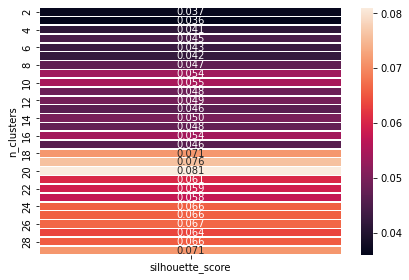

In [ ]:
#3 K-means clustering - Silhouette Score
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,30)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector) # 가장 높은 실루엣 계수와 매핑되는 k

In [ ]:
kmeans = KMeans(n_clusters=20).fit(vector)
print(kmeans.labels_)

[ 1 10  5 13  8  7  7  1  5  7  1  5  7  7  1  7  5  1  5  8  1 12  9  8
  5  5  1  1  8  8  8  5  1  9  7  9  8  5  1  9  0  9  1  1  5  1  7 19
 19  5 16  7 19  9  9  5  5  1  5 13  1  1  9  1  0 10  5  5  1  5  5  1
  9 12  1 19 11  1  2  6  9  7  5 10 16  8  1  7  1  5 10  7  7  8 16  7
 16 10  1  7  8 10  5  9 10  8  8  7  9  8  7  7 10 13  1  8  7  1  5  9
 16 16  1 13  1  7  1  7  0  5  8  7  8  7  1  4  4  6  6  6  1 18 16 11
 18 17  7  0  6 11 14  2  4  6  7 14 15  9  9 14  6  3  4  9  1  6  6  6
 11 15  2  3  6 18  4  3 17 14  4  2 14  7 14 19 19  2  9 15  6  2 11  4
 13  0  6 18  9  9  5 14  7  9 14  1  6 16 14 17 19 16 18 14 17  3 14  9
 15  7 15 16 17  2  9 16  6  3  5 16  0 14  9  6  1  9  3 15  6  4 15 14
  6 11  9  1  5  0  6  5 14 18 13 14 17  9 11  3  0  9 11  6  2  6 17  3
  5 12 14 11 13  2 13  2 14 16 16 17 15 16  2 14  9 18  9 19  3  6  6  6
  2  5 14  6  0 17  9  0  2  2 16  9  9 15  3  9 11 11  9  4 16 15 14  6
 19  9  9  5 19  9 11  4  5  5  9  6 19  3 19  9  3

In [ ]:
cluster2['clusterlst'] = kmeans.labels_
cluster2

,cluster_num,count,top_title,top_noun,clusterlst
0,0,2,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성,1
1,1,6,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",넥슨 라프텔 가명정보 결합 데이터 사이언스 강화,10
2,2,1,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",인공위성 세종 한글과컴퓨터 이미지 데이터,5
3,3,1,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",스페이스데이터 서비스 진출 글로벌 브랜드,13
4,4,2,"농협은행, 마이데이터 친구추천 이벤트 진행",농협은행 마이데이터 친구추천 이벤트 진행,8
...,...,...,...,...,...
498,498,1,"SK브로드밴드, 서울디지털재단과 콘텐츠 업무 협약",SK브로드밴드 서울디지털재단 콘텐츠 업무 협약,15
499,499,1,"이수화학, ICT 전시회 ‘GMV 2022’서 스마트팜 사업 성과 선보인다",이수화학 전시회 스마트팜 사업,9
500,500,1,"신한베트남은행, 'Future Bank Group' 출범 선포...""디지털 뱅크 위...",신한베트남은행 출범 선포 디지털 뱅크 위상 강화,14
501,501,1,한화·교보생명 오너 3세 ‘디지털’ 대결…누가 웃나,한화 교보생명 오너 디지털 대결 누구,3


In [ ]:
for cluster_num in set(cluster2['clusterlst']):
  temp_df = cluster2[cluster2['clusterlst'] == cluster_num]
  print("cluster num : {} Number of news : {}".format(cluster_num, len(temp_df)))
  for title in temp_df['top_title']:
    print(title)
  print()

cluster num : 0 Number of news : 18
빔 소프트웨어, 'VeeamON 2022' 개최... 데이터 보호의 미래 제시
매스웍스코리아, 18일 금융 데이터 분석 및 모델링 웨비나 개최
빔 소프트웨어, 데이터 보호 컨퍼런스 'VeeamON 2022' 개최
국토부, 전국민 참여 '스마트건설 챌린지' 개최…총 상금 4억
서울대병원, AI임상시험센터 연다…20일 개소식
서울대병원 20일 'AI 임상시험센터 개소식' 온·오프라인 개최
서울대병원, AI 임상시험센터 개소식 개최
서울대병원, AI 임상시험센터 개소… "특성화 관리 체계 마련"
솔트룩스, `제조업 특화 AI 기술·사례` 세미나 20일 부산서 개최
솔트룩스이노베이션, '제조업 연계 AI 기술과 솔루션 우수 사례' 세미나 개최
솔트룩스이노베이션, 부산서 '제조업 연계 AI 기술·사례' 세미나 개최
수자원공사, '제1차 디지털 혁신 릴레이 포럼' 개최
서울대병원, ‘AI 임상시험센터’ 20일 개소…AI 의료기기의 객관적 검증 체계 구축
"디자인혁신과 기술융합으로 첨단미래도시 만들자" 양산 스마트시티 전환 토론회 개최
유엔해비타트 한국委, K-핀테크 시장 활성화 세미나 개최
코이카, 디지털 혁신의 날 개최
한국IT서비스학회, '한국 디지털서비스의 새로운 도전과제' 춘계학술대회 개최
실리콘밸리의 인공지능 스타트업은 어떻게 일할까?...업스테이지, 실리콘밸리 AI 스타트업 경험 나누는 '업스테이지 톡' 개최

cluster num : 1 Number of news : 39
'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성
교통사망사고 빅데이터로 도민생명 살린다
백경란 질병청장 "감염병 컨트롤타워 역할 재정립할 것"...전문가위원회·빅데이터 플랫폼 구성
정부, '코로나 빅데이터 플랫폼' 구축…교육·돌봄시설 '공기정화' 지원(종합)
백경란 “빅데이터 기반 ‘과학방역’…감염병 컨트롤타워 정립할 것’”
중대본 “전문가위·빅데이터 플랫폼 구성”…확진자 3만1352명
샴푸 브랜드평판 2022년 

In [ ]:
for cluster_num in set(cluster2['clusterlst']):
  temp_df = cluster2[cluster2['clusterlst'] == cluster_num]
  print("cluster num : {} Number of news : {}".format(cluster_num, len(temp_df)))

cluster num : 0 Number of news : 18
cluster num : 1 Number of news : 39
cluster num : 2 Number of news : 22
cluster num : 3 Number of news : 24
cluster num : 4 Number of news : 11
cluster num : 5 Number of news : 46
cluster num : 6 Number of news : 31
cluster num : 7 Number of news : 29
cluster num : 8 Number of news : 16
cluster num : 9 Number of news : 98
cluster num : 10 Number of news : 8
cluster num : 11 Number of news : 31
cluster num : 12 Number of news : 10
cluster num : 13 Number of news : 10
cluster num : 14 Number of news : 29
cluster num : 15 Number of news : 15
cluster num : 16 Number of news : 26
cluster num : 17 Number of news : 11
cluster num : 18 Number of news : 12
cluster num : 19 Number of news : 17


In [ ]:
cluster2_df = {}
clustering = []
group_title = []
for cluster_num in set(cluster2['clusterlst']):
  clustering.append(cluster_num)
  temp_df = cluster2[cluster2['clusterlst'] == cluster_num]
  title_list = []
  for title in temp_df['top_title']:
    title_list.append(title)
  group_title.append(" ".join(title_list))

cluster2_df['cluster_num'] = clustering
cluster2_df['title'] = group_title

cluster2_df = pd.DataFrame(cluster2_df)

In [ ]:
cluster2_df['noun'] = cluster2_df['title'].apply(lambda x: finalpreprocess_han(x))
cluster2_df['nounlst'] = cluster2_df['title'].apply(lambda x: han2list(x))
cluster2_df

,cluster_num,title,noun,nounlst
0,0,"빔 소프트웨어, 'VeeamON 2022' 개최... 데이터 보호의 미래 제시 매스...",소프트웨어 개최 데이터 보호 미래 제시 매스웍스코리아 금융 데이터 분석 모델링 웨비...,"[소프트웨어, 개최, 데이터, 보호, 미래, 제시, 매스웍스코리아, 금융, 데이터,..."
1,1,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성 교통사망사고 빅데이터로...,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성 교통사망사고 빅데이터 도민생명 질...,"[과학방역, 중대본, 전문가위원회, 빅데이터, 플랫폼, 구성, 교통사망사고, 빅데이..."
2,2,"HDC현대산업개발, '스마트 주차장 솔루션' 개발 HDC현산, HDC랩스와 공동으로...",현대산업개발 스마트 주차장 솔루션 개발 HDC현산 HDC랩스 공동 스마트 기술 선봬...,"[현대산업개발, 스마트, 주차장, 솔루션, 개발, HDC현산, HDC랩스, 공동, ..."
3,3,"신한은행, 베트남에도 ‘디지털’ 입힌다…전담 조직 꾸려 신한베트남銀, 디지털 성장 ...",신한은행 베트남 디지털 전담 조직 신한베트남銀 디지털 성장 추진 퓨처뱅크그룹 출범 ...,"[신한은행, 베트남, 디지털, 전담, 조직, 신한베트남銀, 디지털, 성장, 추진, ..."
4,4,"현대건설, 부산 에코델타 스마트시티 우선협상대상자 선정 LG CNS, 국내최대 스마...",현대건설 부산 에코델타 스마트시티 우선협상대상자 선정 국내최대 스마트시티사업 부산 ...,"[현대건설, 부산, 에코델타, 스마트시티, 우선협상대상자, 선정, 국내최대, 스마트..."
5,5,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다 “랜섬웨어 피해 기...",인공위성 세종 한글과컴퓨터 이미지 데이터 랜섬웨 기업 지불 데이터 복구 실패 질병청...,"[인공위성, 세종, 한글과컴퓨터, 이미지, 데이터, 랜섬웨, 기업, 지불, 데이터,..."
6,6,"LG CNS 컨소시엄, 5.4조원 규모 부산 스마트시티 시범사업 수주 LG CNS,...",컨소시엄 조원 규모 부산 스마트시티 시범사업 수주 부산 국내 최대 규모 스마트시티 ...,"[컨소시엄, 조원, 규모, 부산, 스마트시티, 시범사업, 수주, 부산, 국내, 최대..."
7,7,"하동군, 공공데이터 기업매칭 공모 선정 행안부, 공기관 포함 467개 기관 데이터기...",하동군 공공데이터 기업매칭 공모 선정 행안부 공기관 포함 기관 데이터기반행정 점검 ...,"[하동군, 공공데이터, 기업매칭, 공모, 선정, 행안부, 공기관, 포함, 기관, 데..."
8,8,"농협은행, 마이데이터 친구추천 이벤트 진행 [갈길 먼 마이데이터]② 영국에선 플랫폼...",농협은행 마이데이터 친구추천 이벤트 진행 마이데이터 영국에선 플랫폼 마이데이터 사업...,"[농협은행, 마이데이터, 친구추천, 이벤트, 진행, 마이데이터, 영국에선, 플랫폼,..."
9,9,[빅데이터MSI]18일 오전 주식시장 심리 4단계 '보통' [데이터뉴스]'벤처펀드 ...,빅데이터MSI 오전 주식시장 심리 단계 데이터뉴스 벤처펀드 한국빅데이터학회 빅데이터...,"[빅데이터MSI, 오전, 주식시장, 심리, 단계, 데이터뉴스, 벤처펀드, 한국빅데이..."


### Counter

In [ ]:
keyword = []
for word_list in cluster2_df['nounlst']:
  words = []
  for word in word_list:
    words.append(word)
  key = Counter(words).most_common(1)
  keyword.append(key)

keyword

[[('개최', 15)],
 [('빅데이터', 29)],
 [('스마트', 22)],
 [('디지털', 24)],
 [('에코델타', 11)],
 [('플랫폼', 28)],
 [('부산', 31)],
 [('선정', 22)],
 [('마이데이터', 17)],
 [('AI', 42)],
 [('결합', 8)],
 [('기술', 17)],
 [('지원', 7)],
 [('진출', 5)],
 [('신한베트남은행', 26)],
 [('시니어', 12)],
 [('구축', 25)],
 [('뷰노', 11)],
 [('스마트폰', 8)],
 [('시장', 11)]]

In [ ]:
# 데이터 제외 (이 경우 결과 동일함)
keyword = []
for word_list in cluster2_df['nounlst']:
  words = []
  for word in word_list:
    if word == '데이터':
      pass
    else:
      words.append(word)
  key = Counter(words).most_common(1)
  keyword.append(key)

keyword

[[('개최', 15)],
 [('빅데이터', 29)],
 [('스마트', 22)],
 [('디지털', 24)],
 [('에코델타', 11)],
 [('플랫폼', 28)],
 [('부산', 31)],
 [('선정', 22)],
 [('마이데이터', 17)],
 [('AI', 42)],
 [('결합', 8)],
 [('기술', 17)],
 [('지원', 7)],
 [('진출', 5)],
 [('신한베트남은행', 26)],
 [('시니어', 12)],
 [('구축', 25)],
 [('뷰노', 11)],
 [('스마트폰', 8)],
 [('시장', 11)]]

### Korean KeyBERT

In [ ]:
for cluster_num in cluster2_df['cluster_num']:
  print('cluster_num : {}'.format(cluster_num))
  print('******keyword******')
  doc = cluster2_df['title'][cluster_num]
  tokenized_nouns = cluster2_df['noun'][cluster_num]

  n_gram_range = (1, 1)

  count = CountVectorizer(ngram_range=n_gram_range).fit([tokenized_nouns])
  candidates = count.get_feature_names_out()

  model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
  doc_embedding = model.encode([doc])
  candidate_embeddings = model.encode(candidates)

  top_n = 1
  distances = cosine_similarity(doc_embedding, candidate_embeddings)
  keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
  print(keywords)
  print()

cluster_num : 0
******keyword******
['서울대병원']

cluster_num : 1
******keyword******
['충남']

cluster_num : 2
******keyword******
['픽잇코리아']

cluster_num : 3
******keyword******
['한국농어촌공사']

cluster_num : 4
******keyword******
['한국수자원공사']

cluster_num : 5
******keyword******
['코리아']

cluster_num : 6
******keyword******
['부산']

cluster_num : 7
******keyword******
['부산스마트시티사업']

cluster_num : 8
******keyword******
['삼성카드']

cluster_num : 9
******keyword******
['부산스마트시티']

cluster_num : 10
******keyword******
['한국데이터산업진흥원']

cluster_num : 11
******keyword******
['스마트팜']

cluster_num : 12
******keyword******
['토픽코리아']

cluster_num : 13
******keyword******
['한국축산데이터']

cluster_num : 14
******keyword******
['디지털금융']

cluster_num : 15
******keyword******
['서울디지털재단']

cluster_num : 16
******keyword******
['해외판']

cluster_num : 17
******keyword******
['국내']

cluster_num : 18
******keyword******
['서울디지털재단']

cluster_num : 19
******keyword******
['인천경제자유구역']

